<a href="https://colab.research.google.com/github/mgt412/course_notebooks/blob/master/MGT412_Lecture_9_BinomialTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 9: Binomial Trees for Option Pricing

In [0]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

### Overview of plain vanilla options

Let $S_T$ be the price of a stock at some **maturity** time $T$. Let $K$ be a **strike price**.

A **European call option** gives the holder the right (but not the obligation) to buy the stock for $K$ at maturity $T$. The value of the call option at maturity $T$ is:
$$ c_T = \max(0,S_T-K). $$

A **European put option** gives the holder the right (but not the obligation) to sell the stock for $K$ at maturity $T$. The value of the put option at maturity $T$ is:
$$ p_T = \max(0,K-S_T). $$

American call and put options give the holder the right to buy/sell the stock **at any moment** until $T$.

> **General problem:** what is the value of the option now, i.e., $c_t$ for $t<T$?

## The Cox-Ross-Rubinstein model

1. Consider a call (put) option on a stock maturing after time $T$.
2. The current stock price is $S_0$, strike price is $K$.
3. The volatility of the stock is $\sigma$, risk free rate r .
4. We want to compute the price of the option using a tree with $N$ steps.




### Up-and-down steps (definition)
1. The length of a step is $\Delta t=\frac{T}{N}$.
2. At each step the stock moves up by $u$, or down by $d$:
	\begin{align}
	u&=\exp\left(\sigma \Delta t\right) \\
	d&=u^{-1}
	\end{align}

![alt text](https://github.com/mgt412/course_notebooks/raw/master/Figures/Options_F1.png "Title")

### Risk-neutral probabilities

The risk-neutral probability of an upward jump is $p$, where:
\begin{equation}
p=\frac{\exp\left(r\Delta t\right)-d}{u-d}.
\end{equation}


The value of the option at step $k$ is the discounted risk-neutral expectation at $t+1$:

\begin{equation}
C_{k}=\exp\left(-r\Delta t\right)\left[p \times C_{k+1}^{u}+\left(1-p\right) \times  C_{k+1}^d\right]
\end{equation}


### Background

Remember that to price the option at step $k$ we replicate the payoffs at step $k+1$ using $\Delta$ stocks and $B$ bonds:
\begin{align*}
C_{k+1}^{u}&=\Delta u S + \exp\left(r\Delta t\right) B \\
C_{k+1}^{d}&=\Delta d S + \exp\left(r\Delta t\right) B
\end{align*}
Therefore, solving this system:
\begin{align*}
\Delta &= \frac{C_{k+1}^{u}-C_{k+1}^{d}}{\left(u-d\right)S} \\
B &=\frac{u C_{k+1}^{d}- d C_{k+1}^{u}}{\left(u-d\right)\exp\left(r\Delta t\right) }
\end{align*}


The current value of the option is the current value of the stock and bond portfolio:
\begin{equation}
C_{k}=\Delta S + B.
\end{equation}

Replacing the previously found values for $\Delta$ and $B$,
\begin{equation}
C_{k}=\exp\left(-r\Delta t\right)\left[p C_{k+1}^{u}+\left(1-p\right) C_{k+1}^d\right]
\end{equation}


### Algorithm

Inputs:

* $T$ is the time to maturity (in years),
* $N$ is the number of tree steps,
* $S$ is the current stock price,
* $r$ is the risk free rate (net, absolute terms, i.e., 0.03 for 3\% p.a.),
* $\sigma$ is annual volatility (absolute terms),
* $K$ is the strike price,
* `typeEA` takes value `European` or `American`, 
* `typeCP` takes value `call` or `put`.


In [0]:
# initialize values
T, N, S, r, sigma, K, typeEA, typeCP = 2, 50, 100, 0.03, 0.20, 110, 'European', 'call'

### Option payoff

1. The call option payoff is $\max (S - K, 0)$ whereas the put option payoff is $\max (K - S; 0)$.
2. We transform the `typeCP` variable from a string to a number: 1 for call options, -1 for put options.
3. Then we can write both the call and put option payoff together:
$$ \text{OptionPayoff} = \text{typeCP} \times \max (S - K; 0) $$

In [0]:
if typeCP=="call": # Call or put option
  typeCP=1
else:
  typeCP=-1

### Intermediary variables:

In [0]:
dt=np.float(T)/N # step size
u=np.exp(sigma*np.sqrt(dt)) # up and down steps
d=1/u
p=(np.exp(r*dt)-d)/(u-d) # risk-neutral probabilities

ST=np.zeros(N+1) # Final stock prices vector
option=np.zeros(N+1) # option price vector

### Recursive solution: fill in the terminal values

1. The tree has $N$ steps, hence $N + 1$ terminal values for the stock and the option price.
2. Each possible terminal value is a combination of $k$ downward steps and $N-k$ upward steps, where k varies from zero to N.
3. Terminal option prices are just computed using terminal stock prices (no expectation required).

In [0]:
for i in range(0,N+1):
  ST[i]=S*u**(N-i)*d**i # Fill in terminal stock prices
  option[i]=max(typeCP*(ST[i]-K),0) # Fill in terminal option prices  

### Moving backwards:

Starting from the vector option of terminal values, loop:
1. Backwards over tree levels ($i$ loop);
2. Forward over cells on a tree level ($j$ loop)
3. At each new tree level, we overwrite the option vector with the discounted expected values of the option on the following level.

![alt text](https://github.com/mgt412/course_notebooks/raw/master/Figures/Options_F2.png "Title")

In [0]:
for i in range(N-1,-1,-1):
  for j in range(0,i+1):
    option[j]=np.exp(-r*dt)*(p*option[j]+(1-p)*option[j+1])

For an American option, at each node $j$ we:
1. Compute the stock price at that node.
2. Compare the European option value with the payoff on immediate exercise (using the stock price we just computed).
3. We keep the largest value of the two.

In [0]:
for i in range(N-1,-1,-1):
  for j in range(0,i+1):
    option[j]=np.exp(-r*dt)*(p*option[j]+(1-p)*option[j+1])
    if typeEA=="American":
      ST[j]=np.exp(-r*dt)*(p*ST[j]+(1-p)*ST[j+1])
      option[j]=max(option[j], max(typeCP*(ST[j]-K),0))

## Binomial tree function

In [0]:
def binomialtree(T,N,S,r,sigma,K, typeEA, typeCP):

    if typeCP=="call": # Call or put option
        typeCP=1
    else:
        typeCP=-1

    dt=np.float(T)/N # step size
    u=np.exp(sigma*np.sqrt(dt)) # up and down steps
    d=1/u
    p=(np.exp(r*dt)-d)/(u-d) # risk-neutral probabilities

    ST=np.zeros(N+1) # Final stock prices vector
    option=np.zeros(N+1) # option price vector

    for i in range(0,N+1):
        ST[i]=S*u**(N-i)*d**i # Fill in terminal stock prices
        option[i]=max(typeCP*(ST[i]-K),0) # Fill in terminal option prices
    
    for i in range(N-1,-1,-1):
        for j in range(0,i+1):
            option[j]=np.exp(-r*dt)*(p*option[j]+(1-p)*option[j+1])
            if typeEA=="American":
                ST[j]=np.exp(-r*dt)*(p*ST[j]+(1-p)*ST[j+1])
                option[j]=max(option[j], max(typeCP*(ST[j]-K),0))

    return option[0]

In [25]:
binomialtree(T,N,S,r,sigma,K,typeEA, "call")

9.745036447735755

## Black-Scholes option price

The Black-Scholes formula for pricing a call option is:
$$ c = S_t \times N(d_1) - K e^{-rT} N(d_2) $$

where $d_1=\frac{\log\frac{S_t}{K}+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma \sqrt{T}}$ and $d_2=d_1-\sigma\sqrt{T}$.

In [0]:
from scipy.stats import norm

In [0]:
def BlackScholes(T,S,K,sigma,r,typeCP):
  d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
  d2=d1-sigma*np.sqrt(T)
  
  call=S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
  put = K*np.exp(-r*T)*norm.cdf(-d2)- S*norm.cdf(-d1)
  
  if typeCP=='call':
    return call
  else:
    return put

In [30]:
BlackScholes(T,S,K,sigma,r,'put')

13.333935020075948

In [0]:
N_space=np.linspace(2,100,99) # number of stepts in the binomial tree

binomial_space=[binomialtree(T,int(x),S,r,sigma,K,typeEA, "call") for x in N_space]
BS_space=[BlackScholes(T,S,K,sigma,r,'call') for x in N_space]

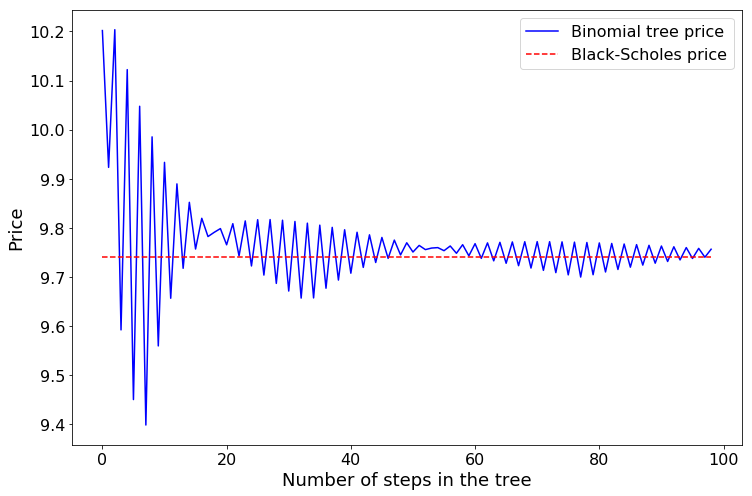

In [48]:
fig=plt.figure(figsize=(12,8))
plt.plot(binomial_space,label='Binomial tree price',c='b')
plt.plot(BS_space,label='Black-Scholes price',c='r',ls='--')
plt.xlabel('Number of steps in the tree',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16,loc='best')

### Put-call parity

We can verify if the put-call parity holds, or:

$$ C - P = S - Ke^{-r T} $$

In [0]:
def put_call_parity(T,N,S,r,sigma,K):
  call=binomialtree(T,N,S,r,sigma,K, "European", "call")
  put=binomialtree(T,N,S,r,sigma,K, "European", "put")
  
  return (call-put)-(S-K*np.exp(-r*T))

The function returns essentially zero.

In [55]:
put_call_parity(T,20,S,r,sigma,K)

1.3145040611561853e-13

### Option properties

Option price should increase with volatility.

In [0]:
s_space=np.linspace(0.1,0.2,1000) # number of stepts in the binomial tree

sigma_space_bin=[binomialtree(T,50,S,r,s,K,typeEA, "call") for s in s_space]
sigma_space_BS=[BlackScholes(T,S,K,s,r,'call') for s in s_space]

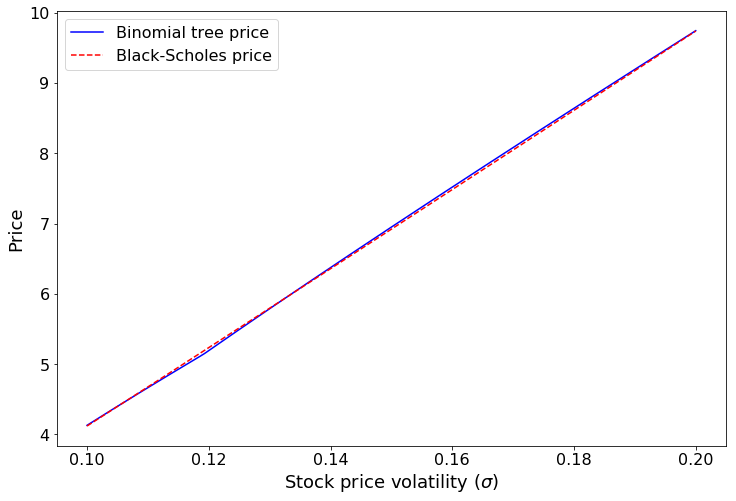

In [73]:
fig=plt.figure(figsize=(12,8))
plt.plot(s_space, sigma_space_bin,label='Binomial tree price',c='b')
plt.plot(s_space, sigma_space_BS,label='Black-Scholes price',c='r',ls='--')
plt.xlabel('Stock price volatility ($\sigma$)',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16,loc='best')